# To do:

See if I can integrate locu

Set up pipeline for other regressors?

In [1]:
import os
import importlib
import pandas as pd
import numpy as np
%matplotlib inline
import pdb
import json
import time
from Kibbeh.src import feature_extract_resto
from Kibbeh.src import API_io
import re
import matplotlib.pyplot as plt
import ast

In [2]:
working_dir = 'C:\\Users\\Chauncey\\Documents\\GitHub\\Kibbeh'
#working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\Kibbeh'
seattle_zips = pd.read_csv(working_dir + '\\seattle_zips.csv')['Zip'].values

In [3]:
# load foursquare restaurants and ratings
def load_json(json_name):
    with open(json_name) as json_file:
        return json.load(json_file)
seattle_top_restos = load_json('seattle_fs_restaurant_list.json')
portland_top_restos = load_json('portland_fs_restaurant_list.json')
bay_area_top_restos = load_json('bay_area_fs_restaurant_list.json')
fs_top_restos = list(seattle_top_restos)
fs_top_restos.extend(portland_top_restos)
fs_top_restos.extend(bay_area_top_restos)
len(fs_top_restos)

10778

In [4]:
# load foursquare menus
seattle_fs_menus_rated = load_json('seattle_fs_restaurant_menus.json')
portland_fs_menus_rated = load_json('portland_fs_restaurant_menus.json')
bay_area_fs_menus_rated = load_json('bay_area_fs_restaurant_menus.json')
fs_menus_rated = list(seattle_fs_menus_rated)
fs_menus_rated.extend(portland_fs_menus_rated)
fs_menus_rated.extend(bay_area_fs_menus_rated)
len(fs_menus_rated)

3409

In [6]:
# load yelp restaurants
with open('seattle_yelp_restaurant_list.json', 'r') as json_file:
    yelp_restos = json.load( json_file)
len(yelp_restos)

1000

In [7]:
# load from local json
with open('seattle_locu_restaurant_list.json', 'r') as json_file:
    locu_restos = json.load( json_file)
len(locu_restos)

1564

In [8]:
# load
with open('seattle_locu_menu_list.json', 'r') as json_file:
    locu_menus = json.load( json_file)
len(locu_menus)

399

# Feature extraction
## Yelp restaurants

In [11]:
yelp_df = feature_extract_resto.feature_extract_yelp_list(yelp_restos)
yelp_df.head(3)

,categories,id,phone,rating,review_count
name,,,,,
Piroshky Piroshky,"[Bakeries, Russian]",piroshky-piroshky-seattle,2064416068,4.5,3235
Paseo,"[Caribbean, Cuban, Sandwiches]",paseo-seattle-3,2065457440,4.5,4099
Umma's Lunch Box,"[Korean, Buffets]",ummas-lunch-box-seattle,2068543166,4.5,184


In [ ]:
pd.scatter_matrix(ganma);

In [ ]:
with open(working_dir + 'yelp_df.csv', 'w', encoding='utf8') as csv_file:
    yelp_df.to_csv(csv_file,  sep=';')

In [ ]:
with open(working_dir + 'yelp_df.csv', 'r', encoding='utf8') as csv_file:
    yelp_df = pd.read_csv(csv_file, sep=';', index_col='name', dtype={'phone':str})
    yelp_df['categories'] = yelp_df['categories'].apply(ast.literal_eval )

## Foursquare restaurant feature extraction

### Check that different cities have similar ratings

In [5]:
portland_restos_rated = [x for x in portland_top_restos if 'rating' in x['venue'].keys()]
len(portland_restos_rated)

1151

In [6]:
seattle_restos_rated = [x for x in seattle_top_restos if 'rating' in x['venue'].keys()]
len(seattle_restos_rated)

2289

In [7]:
bay_area_restos_rated = [x for x in bay_area_top_restos if 'rating' in x['venue'].keys()]
len(bay_area_restos_rated)

5548

In [8]:
def z_score_col(df, col_name):
    df['z_' + col_name] = (df[col_name] - df[col_name].mean()) / df[col_name].std()
    return df

In [9]:
# z_score normalize portland ratings
importlib.reload(feature_extract_resto)
portland_resto_df = feature_extract_resto.feature_extract_fs_list(portland_restos_rated)
portland_resto_df.drop_duplicates(inplace=True)
portland_resto_df = z_score_col(portland_resto_df, 'rating')
#portland_resto_df.describe()

In [10]:
# z_score normalize seattle ratings
seattle_resto_df = feature_extract_resto.feature_extract_fs_list(seattle_restos_rated)
seattle_resto_df.drop_duplicates(inplace=True)
seattle_resto_df = z_score_col(seattle_resto_df, 'rating')
#seattle_resto_df.describe()

In [11]:
# z_score normalize seattle ratings
bay_area_resto_df = feature_extract_resto.feature_extract_fs_list(bay_area_restos_rated)
bay_area_resto_df.drop_duplicates(inplace=True)
bay_area_resto_df = z_score_col(bay_area_resto_df, 'rating')
#bay_area_resto_df.describe()

In [12]:
fs_resto_df = pd.concat([seattle_resto_df, portland_resto_df, bay_area_resto_df])

C:\Users\Chauncey\Anaconda3\lib\site-packages\pandas\tools\plotting.py:3235: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "is being cleared", UserWarning)


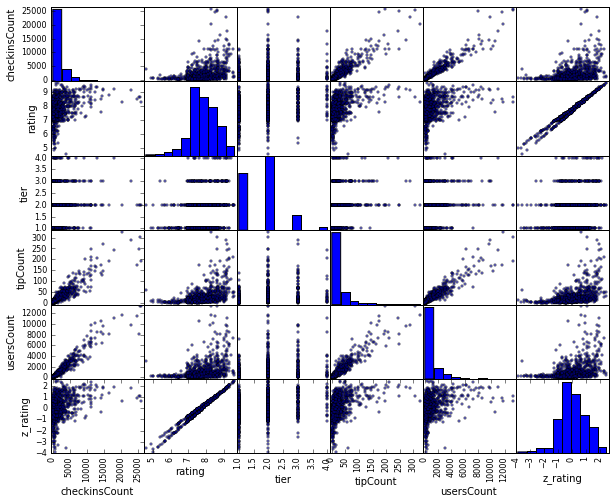

In [13]:
fig, fs_ax = plt.subplots(1, figsize=[10, 8]);
pd.scatter_matrix(fs_resto_df.sample(n=1000), ax=fs_ax);

In [14]:
# get ids of the menus I have
fs_menu_ids = [menu['id'] for menu in fs_menus_rated]
len(fs_menu_ids)

3409

## Foursquare menu feature extraction
Each menu json has keys: id, provider, menus

Each menus dict has keys: count (# of "menus"), and items (a LIST of menus, even if theree's just one)

Each element of items has keys: name (of menu), menuId, description, and entries (a dict)

Each entries has keys: count (# of items on menu), and list of items

Each element of items has keys: name, sectionId, description, and MORE entries

Each entries has keys: count, and a list of items

The FINAL items is a list, each element has: description, entryId, and name

In [15]:
import nltk
import Kibbeh.src.feature_extract_menu as fem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
menu_list = [json.dumps(menu['menus']) for menu in fs_menus_rated] # convert json to string
def strip_punct(menu):
    menu =re.sub("[^a-zA-Z0-9]", " ", menu )
    menu =re.sub("[0-9]+", " ", menu )
    return menu
menu_list2 = list(map(strip_punct, menu_list)) # remove punctuation

In [17]:
# preprocessing that turns all to lower case, removes punctuation, and gets rid of some stop words
# super slow, and should probably be using built in
importlib.reload(fem)
menu_obj = [fem.wordify_json_menu(menu['menus'], set(stopwords.words()) ) for menu in fs_menus_rated]
[parsed_fs_menus, num_items, num_sections, num_menus] = zip(*menu_obj)
parsed_fs_menus = list(parsed_fs_menus)
len(parsed_fs_menus)

3409

## Locu menu parsing
Each json is a list: first element is the name, second element is a json object of the menu
Each menu is a list of sub_menus
Each sub_menu has keys: menu_name, sections, currency_symbol

In [14]:
# menu[0] has the restaurant name; get all restaurants whose name is in the foursquare dataframe
locu_fs_menus = [menu for menu in locu_menus if menu[0] in fs_resto_df.index]
len(locu_fs_menus)

245

In [15]:
def remove_duplicate_locu_restos(locu_resto_list):
    locu_names = {x[0] for x in locu_resto_list}
    new_locu_restos = []
    for cur_resto in locu_resto_list:
        #pdb.set_trace()
        if cur_resto[0] in locu_names:
            locu_names.remove(cur_resto[0])
            new_locu_restos.append(cur_resto)
    return new_locu_restos
locu_fs_menus = remove_duplicate_locu_restos(locu_fs_menus)
len(locu_fs_menus)

222

In [16]:
# get the foursquare ids of the locu restaurants
def parse_ids(ids_in):
    if type(ids_in) == str:
        return ids_in
    else:
        return list(ids_in)[0]
locu_fs_ids = [parse_ids(fs_resto_df.loc[ menu[0]]['id'] ) for menu in locu_fs_menus]
len(locu_fs_ids)

222

In [20]:
# locu menus for which I don't have a foursquare menu
locu_menu_no_fs_menu = [menu for i, menu in enumerate(locu_fs_menus) if locu_fs_ids[i] not in fs_id]
len(locu_menu_no_fs_menu)

211

In [21]:
locu_fs_ids = [parse_ids(fs_resto_df.loc[ menu[0]]['id'] ) for menu in locu_menu_no_fs_menu]
locu_fs_ids = np.unique(np.array(locu_fs_ids))
len(locu_fs_ids)

211

In [22]:
locu_menu_has_fs_id = [menu for i, menu in enumerate(locu_menu_no_fs_menu) if locu_fs_ids[i] in fs_resto_df.id.values]
len(locu_menu_has_fs_id)

211

In [38]:
importlib.reload(fem)
menu_obj = [fem.wordify_json_menu(menu, stopwords.words()) for menu in locu_menu_no_fs_menu]
[parsed_locu_menus, num_items, num_sections, num_menus] = zip(*menu_obj)
parsed_locu_menus = list(parsed_locu_menus)
len(parsed_locu_menus)

211

### Vectorize menu - bag of words, N-grams, and tf-idf

In [18]:
#combined_menus = list(parsed_fs_menus) # without the list(), it is a variable reference, not a copy
#combined_menus.extend(parsed_locu_menus)
combined_menus = list(parsed_fs_menus)
len(combined_menus)

3409

In [19]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
#vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [20]:
bigram_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words(), analyzer='word',
                                    tokenizer=LemmaTokenizer(), ngram_range=(1,2),
                                    #token_pattern=u'(?u)\\b[A-Za-z]{3,}\\b',
                                    min_df= 5, max_df = 0.5, max_features=10000)
unigram_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words(), analyzer='word',
                                     tokenizer=LemmaTokenizer(), ngram_range=(1,1),
                                     #token_pattern=u'(?u)\\b[A-Za-z]{3,}\\b',
                                     min_df= 5, max_df = 0.5)

In [21]:
unigram_features = unigram_vectorizer.fit_transform(combined_menus)

In [22]:
bigram_features = bigram_vectorizer.fit_transform(combined_menus)
bigram_features.shape

(3409, 10000)

In [60]:
bigram_vectorizer.get_feature_names()[-1000:-990]

['tempura roll',
 'tempura sauce',
 'tempura shrimp',
 'tempura udon',
 'ten',
 'tender',
 'tender addition',
 'tender beef',
 'tender chicken',
 'tender chunk']

### Select subset of foursquare dataframe with the menu ids

In [23]:
fs_menu_df = fs_resto_df.query('id in @fs_menu_ids')
#fs_menu_df = fs_resto_df.query('id in @locu_fs_ids')
#fs_menu_df = fs_resto_df.query('id in @fs_id_menus or id in @locu_fs_ids')
fs_menu_df.shape

(3409, 9)

In [24]:
# make sure the menus are in same order as the dataframe
fs_menu_df['name2'] = fs_menu_df.index.values
fs_menu_df.set_index('id', inplace=True)
fs_menu_df = fs_menu_df.reindex(fs_menu_ids)

C:\Users\Chauncey\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


## Tf-idf

In [46]:
#combined_menus = list(parsed_locu_menus) # without the list(), it is a variable reference, not a copy
#combined_menus.extend(parsed_fs_menus)
combined_menus = list(parsed_fs_menus)
len(combined_menus)

3409

In [26]:
tfidf_vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words(), analyzer='word',
                                  tokenizer=LemmaTokenizer(), ngram_range=(1,2),
                                  #token_pattern=u'(?u)\\b[A-Za-z]{3,}\\b',
                                  min_df= 5, max_df = 0.5, max_features=10000, use_idf=True)
#tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=5000, min_df=2,
#                                   stop_words='english', token_pattern=u'(?u)\\b[A-Za-z]{3,}\\b',
#                                   use_idf=True)

In [27]:
tfidf_features = tfidf_vectorizer.fit_transform(combined_menus)
tfidf_features.shape

(3409, 10000)

### Gradient boosted trees

In [93]:
menu_boost_regressor = GradientBoostingRegressor(n_estimators=50, max_depth = 20, min_samples_leaf=4)

In [39]:
#X_train, X_test, y_train, y_test = train_test_split(tfidf_features, fs_menu_df['rating'], test_size=0.2, random_state=30)
X_train, X_test, y_train, y_test = train_test_split(bigram_features, fs_menu_df['z_rating'], test_size=0.2, random_state=42)
#menu_boost_regressor.fit(X_train, y_train)
#menu_boost_regressor.score(X_test.toarray(), y_test)

In [ ]:
importances = menu_boost_regressor.feature_importances_
indices = np.argsort(importances)
bigram_feature_names = np.array(bigram_vectorizer.get_feature_names() )
list(sorted(zip(importances, bigram_feature_names), reverse = True) )[:20]

### Random forests

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [34]:
menu_rf_regressor = RandomForestRegressor( min_samples_leaf = 5, n_estimators = 150,
                                          min_samples_split = 10, n_jobs = 2)
# previously ran a grid search that found max_depth 30 was better than 20,
# and min_samples_split=10 was better than 20 or 100
# second grid search found 150 estimators > 100
rf_dict = { 'max_depth' : [ 30, 40] }
forest_grid = GridSearchCV(menu_rf_regressor, param_grid = rf_dict, cv = 3, n_jobs = 2)

In [35]:
forest_grid.fit(bigram_features, fs_menu_df['z_rating'])
forest_grid.best_params_

{'max_depth': 40}

In [36]:
best_forest = forest_grid.best_estimator_

In [37]:
best_forest.score(bigram_features, fs_menu_df['z_rating'])

0.74981171327275786

In [40]:
best_forest.fit(X_train, y_train)
best_forest.score(X_test, y_test)

0.37763071048716873

In [41]:
importances = best_forest.feature_importances_
indices = np.argsort(importances)
bigram_feature_names = np.array(bigram_vectorizer.get_feature_names() )
list(sorted(zip(importances, bigram_feature_names), reverse = True) )[:20]

[(0.062587320089476553, 'bacon ranch'),
 (0.056737542142188895, 'bun big'),
 (0.048449357415438141, 'bun'),
 (0.036188606236802937, 'loaded'),
 (0.02268200568902165, 'beet'),
 (0.019620454647762728, 'ranch melt'),
 (0.0097182579842205723, 'house made'),
 (0.0080415654348258755, 'ripe tomato'),
 (0.0067871303031382044, 'pickled'),
 (0.0057361324776893314, 'caesar'),
 (0.0053756921556631027, 'real'),
 (0.005246666155767324, 'cilantro'),
 (0.0046579028131343621, 'cru'),
 (0.0043812884721756672, 'breast'),
 (0.0043214763569914645, 'tender'),
 (0.0042243207879554909, 'addition chicken'),
 (0.0042042192394296908, 'cured'),
 (0.0040696033736769277, 'bleu cheese'),
 (0.0040632369519320302, 'grilled chicken'),
 (0.0035743472701131392, 'confit')]

In [200]:
first_tree = menu_boost_regressor.estimators_[0][0]
from sklearn.tree import export_graphviz
export_graphviz(first_tree.tree_, out_file='menu_tree.dot', feature_names = menu_feature_names)

In [64]:
def calc_ratings_ngram( feature_names, features, word, df):
    word_index = np.arange(10000)[feature_names == word]
    word_feature = features[:,word_index].toarray()
    word_feature = np.array([x[0] for x in word_feature] )
    print('Average rating for {0}: {1}'.format(word, df['rating'][word_feature > 0 ].mean())) 
    print('Restaurants with menus containing {0}: {1}'.format(word,
                              df[['rating', 'name2']][word_feature > 0 ][:5]) )

In [75]:
calc_ratings_ngram(menu_feature_names, menu_features, 'shredded cheddar', fs_menu_df )

Average rating for shredded cheddar: 6.372164948453607
Restaurants with menus containing shredded cheddar:                           rating            name2
id                                               
4b58b351f964a5205f6628e3     6.4           Arby's
4c1e9d1763750f478609ba67     6.1  Jack in the Box
4be79537ee96c9284430fdbf     6.0       McDonald's
4b12da54f964a520718f23e3     5.9          Denny's
4b70caa8f964a520d42e2de3     5.7  Jack in the Box


In [211]:
fs_menu_df['rating'].mean()

7.6059268600252254

### Elasticnet regression

In [ ]:
from sklearn.linear_model import ElasticNetCV
menu_elastic_net = ElasticNetCV(cv = 2, normalize=True, max_iter=500, n_jobs=2)

In [ ]:
menu_elastic_net.fit(menu_features, fs_menu_df['rating'])

In [ ]:
menu_elastic_net.score(menu_features, fs_menu_df['rating'])

In [ ]:
best_coeff = np.argsort(np.abs(menu_elastic_net.coef_))[-25:]
list(zip(menu_feature_names[best_coeff], menu_elastic_net.coef_[best_coeff]))

## Latent Dirichlet Allocation

In [115]:
from sklearn.decomposition import LatentDirichletAllocation
menu_lda = LatentDirichletAllocation(n_topics = 10, max_iter =10, random_state =37)
menu_lda.fit(bigram_features)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=37,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [116]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [122]:
print_top_words(menu_lda, bigram_feature_names, 20)

Topic #0:
crispy bun premium crispy chicken tortilla grilled chicken creamy ranch crisp juicy seasoned white meat cheddar slice american patty wrap snack strip soft
Topic #1:
tortilla salsa guacamole sour sour cream taco chile corn burrito cilantro avocado enchilada rice bean flour steak black bean mexican flour tortilla corn tortilla pico
Topic #2:
noodle prawn tofu curry sauteed chili thai chicken addition carrot sour soup addition fried rice basil peanut rice addition bell bell pepper broccoli coconut sauce addition
Topic #3:
vinaigrette lemon organic butter smoked house made made avocado aioli apple chocolate seasonal fry olive fruit salmon cake arugula toasted bread
Topic #4:
crab steak cocktail lobster salmon calorie signature fry lime prawn vodka crispy clam juice filet classic wood beer wine fish
Topic #5:
sandwich burger turkey cheddar fry bbq breast jack lettuce tomato french bread swiss steak mayo smoked avocado chicken breast sausage cheddar cheese sliced
Topic #6:
roll tun

### Get all keys in json

In [ ]:
def get_keys(json, json_keys = set()):
    #pdb.set_trace()
    if type(json) == dict:
        for key in json.keys():
            json_keys.add( key )
            json_keys.update(get_keys(json[key]))
    elif type(json) == list:
        for element in json:
            json_keys.update(get_keys(element))
    return json_keys

In [ ]:
all_keys = get_keys(fs_menus_rated)
all_keys